# **The Bidirectional Relationship of Monetary Policy and Factor Premia**

## Dataset

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector

In [340]:
pip install xlrd

In [341]:
pip install openpyxl

In [342]:
import xlrd
import openpyxl

In [343]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Cleaning**

# I. Stance of Monetary Policy

When measuring the stance of monetary policy, Cooper (2020) use the following formula:
$$MP_t = FF_t - FF_t^* = FF_t - (RFF_t^* \ + 10Y IE)$$

where $MP_t$ is the stance of monetary policy, $FF_t$ is the federal funds rate, and $FF_t^*$ is the estimate of the (nominal) neutral rate ($FF^*$). Cooper (2020) set $FF^*$ as the sum of $RFF_t^*$ (the Laubach and Williams neutral real rate of interest) and $10Y IE$ (the Hoey-Philadelphia Fed Survey of Professional Forecasters (SPF) 10-year inflation expectations, as reported in the FRB/US data set).

Following that formula, we must merge those three components: $FF_t$, $RFF_t^*$, and $10Y IE$.

## A. Federal Funds Rate

In [344]:
ffr = pd.read_excel('/content/drive/MyDrive/fedfunds.xls')
ffr.head()

,observation_date,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


What is the data type of the feature (1) "FEDFUNDS" and (2) observation_date? Question (1) is important because the federal funds raet is an element of the calculation of the stance of monetary policy. Question (2) is also vital becuase to merge this dataset with others, the dates have to be standardized.

In [345]:
ffr.dtypes  #Check data type

observation_date    datetime64[ns]
FEDFUNDS                   float64
dtype: object

(1) Currently, the dataframe has the federal funds rate as float type, which is the appropriate data type when computing the stance of monetary policy. So, we do not have to fchange the data type of this feature.

(2) We also don't have to change the "observation_date" since it is already in "datetime64." Meaning, if we had to change standardize the dates, that format meets the standard, and adapting that variable ("observation_date") when standardizing and merging will be easy.

### B. $RFF_t^*$

In [346]:
#R star
rff = pd.read_excel('/content/drive/MyDrive/r_star.xlsx')

rff.rename(columns={'rstar': 'RSTAR'}, inplace=True)  #Match format and style of column title to other dataframes
rff.tail()

,Date,RSTAR
246,2022-07-01,1.166590
247,2022-10-01,1.172628
248,2023-01-01,1.180203
249,2023-04-01,1.187966
250,2023-07-01,1.187966


For similar reasons as for the federal funds rate, for the component $FF^*$, we must check the data type of "RSTAR" and "Date."

In [347]:
rff.dtypes  #Check data type

Date     datetime64[ns]
RSTAR           float64
dtype: object

The data types are the same as the federal funds rate in part A (Section I). So, no change is necessary.

## C. SPF 10-year Inflation Expectations

In [348]:
#SPF 10 year inflation expectations
spf_10yr_inflation_exp = pd.read_excel('/content/drive/MyDrive/spf_10_yr_inflation_expectation.xlsx')
spf_10yr_inflation_exp.tail(10)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,YEAR,QUARTER,INFCPI10YR
206,2021,3,2.4367
207,2021,4,2.5500
208,2022,1,2.4981
209,2022,2,2.8000
210,2022,3,2.8000
211,2022,4,2.9500
212,2023,1,2.3700
213,2023,2,2.3555
214,2023,3,2.4000
215,2023,4,2.4000


As for the other datasets, we must check the datatypes.

In [349]:
spf_10yr_inflation_exp.dtypes

YEAR            int64
QUARTER         int64
INFCPI10YR    float64
dtype: object

The datatype for the feature "INFCPI10YR" matches with the datatype of the federal funds rate and $FF^*$. However, the date for this dataset is set in two seperate columns: "YEAR" and "QUARTER." Also, they have an "integer" data type.

To perform operations, information must be the same type of data type as similar information in other dataframes. Specifically, the components of the stance of monetary policy must be float and the dates must be datetime format. In this case, value is a float. Also, the SPF 10-year inflation expectations have date in two seprate columns, making them integers.

## D. Standardize Dates

All datasets but "spf_10yr_inflation_exp" have monthly frequency. Monthly frequency can give more granular data. So, to delegate the different time frequencies, spf_10yr_inflation_exp must have monthly frequency instead of quarterly frequency when merging.   

To achieve such a purpose, the "Date" column must be one and have a format similar to monthly frequency.

In [350]:
months_dict = {1: '-01-01', 2: '-04-01', 3: '-07-01', 4: '-10-01'}  #Set dictionary that converts the quarters into month format

# Create "Date" column in monthly frequency
spf_10yr_inflation_exp['Date'] = spf_10yr_inflation_exp.apply(
    lambda row: pd.to_datetime(str(int(row['YEAR'])) + months_dict[int(row['QUARTER'])]), axis=1
)

spf_10yr_inflation_exp = spf_10yr_inflation_exp.drop(["YEAR", "QUARTER"], axis=1)     #Drop irrelevant columns

spf_10yr_inflation_exp.tail(10)

,INFCPI10YR,Date
206,2.4367,2021-07-01
207,2.5500,2021-10-01
208,2.4981,2022-01-01
209,2.8000,2022-04-01
210,2.8000,2022-07-01
211,2.9500,2022-10-01
212,2.3700,2023-01-01
213,2.3555,2023-04-01
214,2.4000,2023-07-01
215,2.4000,2023-10-01


In [351]:
spf_10yr_inflation_exp.dtypes

INFCPI10YR           float64
Date          datetime64[ns]
dtype: object

As seen, now, the dates in quarterly frequency in the dataset are in one column and have been converted into monthly frequency. Also, the "Date" variable is in "datetime" format, as in other datasets.

## E. Merging & Calculating Stance of Monetary Policy

 With the dates standardized across all datasets, they can be merged. Since rff and spf_10yr_inflation_exp as datasets have quarterly frequency, the values will be repeated across each quarter with forward fill starting from the first date r-star is available when merged with the federal funds rate (which is at a monthly frequency). This decision is made because monthly frequency will yield a more granular perspective.

In [352]:
#Find the first date at which rr* is available
first_non_nan_row = spf_10yr_inflation_exp.loc[spf_10yr_inflation_exp['INFCPI10YR'].notna()].iloc[0]
print(first_non_nan_row)

INFCPI10YR                    4.0
Date          1991-10-01 00:00:00
Name: 87, dtype: object


In [353]:
#Drop all rows before 1991-10-01 in ffr dataset
ffr_filtered = ffr.loc[ffr["observation_date"] >= pd.to_datetime("1991-10-01")]

mp_stance = pd.merge(ffr_filtered, rff, left_on="observation_date", right_on="Date", how="left")
mp_stance["observation_date"] = pd.to_datetime(mp_stance["observation_date"] )
mp_stance['RSTAR'].fillna(method='ffill', inplace=True)   #Replace NaN values with forward fill
mp_stance = mp_stance.drop("Date", axis=1)

mp_stance.head(10)

,observation_date,FEDFUNDS,RSTAR
0,1991-10-01,5.21,2.272380
1,1991-11-01,4.81,2.272380
2,1991-12-01,4.43,2.272380
3,1992-01-01,4.03,2.265791
4,1992-02-01,4.06,2.265791
5,1992-03-01,3.98,2.265791
6,1992-04-01,3.73,2.260174
7,1992-05-01,3.82,2.260174
8,1992-06-01,3.76,2.260174
9,1992-07-01,3.25,2.257419


In [354]:
mp_stance = pd.merge(mp_stance, spf_10yr_inflation_exp, left_on="observation_date", right_on="Date", how="left")
mp_stance['INFCPI10YR'].fillna(method='ffill', inplace=True)   #Replace NaN values with forward fill
mp_stance = mp_stance.drop("Date", axis=1)

mp_stance.tail(10)

,observation_date,FEDFUNDS,RSTAR,INFCPI10YR
376,2023-02-01,4.57,1.180203,2.3700
377,2023-03-01,4.65,1.180203,2.3700
378,2023-04-01,4.83,1.187966,2.3555
379,2023-05-01,5.06,1.187966,2.3555
380,2023-06-01,5.08,1.187966,2.3555
381,2023-07-01,5.12,1.187966,2.4000
382,2023-08-01,5.33,1.187966,2.4000
383,2023-09-01,5.33,1.187966,2.4000
384,2023-10-01,5.33,1.187966,2.4000
385,2023-11-01,5.33,1.187966,2.4000


Now, the dataset has all of the necessary components to calculate the monetary policy stance at a monthly frequency.

### F. Compute Monetary Policy Stance

Currenlty, the merged datast has all of the necessary components to calculate the monetary policy stance without the variable itself.

In [355]:
mp_stance["MPSTANCE"] = mp_stance["FEDFUNDS"] - (mp_stance["RSTAR"] + mp_stance["INFCPI10YR"])    #Use formula

mp_stance = mp_stance.drop(["FEDFUNDS", "RSTAR", "INFCPI10YR"], axis=1)   #Drop irrelevant columns
mp_stance["observation_date"] = mp_stance["observation_date"].dt.strftime("%b-%Y") #Set month-year format to prepare for the merging with the x-variables

mp_stance.head(10)

,observation_date,MPSTANCE
0,Oct-1991,-1.062380
1,Nov-1991,-1.462380
2,Dec-1991,-1.842380
3,Jan-1992,-1.935791
4,Feb-1992,-1.905791
5,Mar-1992,-1.985791
6,Apr-1992,-2.430174
7,May-1992,-2.340174
8,Jun-1992,-2.400174
9,Jul-1992,-2.757419


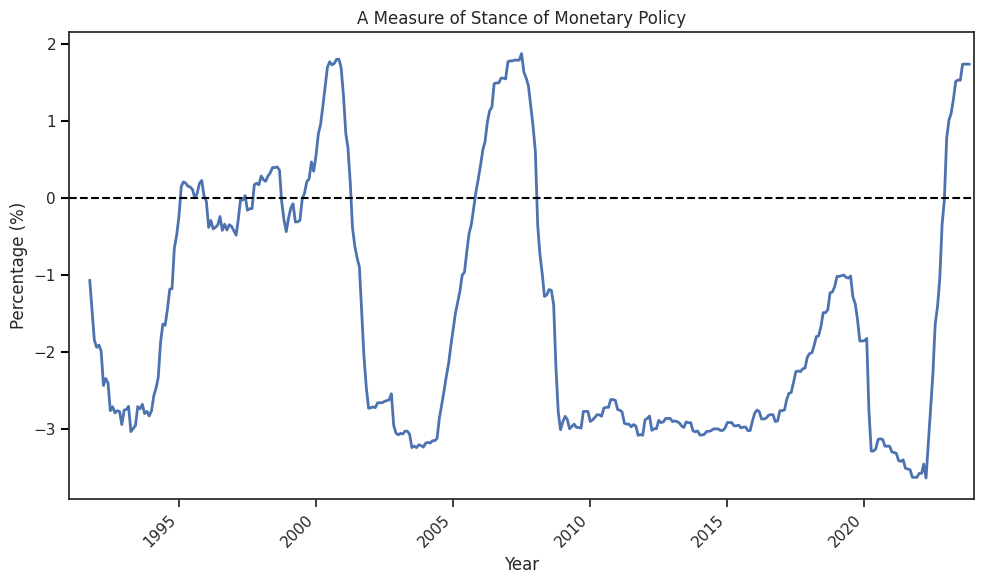

In [356]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set(style='ticks')

mp_stance_graph = mp_stance.copy()

if not pd.api.types.is_datetime64_dtype(mp_stance_graph['observation_date']):
    mp_stance_graph['observation_date'] = pd.to_datetime(mp_stance_graph['observation_date'])

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=mp_stance_graph, x='observation_date', y='MPSTANCE', ax=ax, linewidth=2)

ax.axhline(0, color='black', linewidth=1.5, linestyle='--')
ax.yaxis.set_tick_params(width=1.5, color='black')

# Set x-axis limits to 1991 and 2023:
ax.set_xlim([pd.to_datetime('1991-01-01'), pd.to_datetime('2023-12-31')])

# Adjust for yearly display with 5-year intervals:
ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter("%Y %% 5"))
plt.xticks(rotation=45, ha='right')  # Rotate for readability
ax.set_xlabel('Year')

ax.set_title("A Measure of Stance of Monetary Policy")
ax.set_ylabel('Percentage (%)')
fig.tight_layout()
plt.show()


As seeen from the graph above, the measure of the stance of monetary policy matches with the original source, confirming the accuracy of the MPSTANCE as a variable.

## II. Factor Premia Across Asset Classes

### A. Change: Shape of Dataset

Ilmanen (2019) publish and update a dataset of factor premia across different asset classes. The first 30 rows of the uploaded dataset show empty values and unnamed column names.

In [357]:
factor_premia = pd.read_excel('/Century of Factor Premia Monthly.xlsx')
factor_premia.head(30)

,"AQR Capital Management, LLC — How Do Factor Premia Vary Over Time? A Century of Evidence",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,This file contains monthly self-financing exce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,The portfolios are an updated and extended ver...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,The portfolio construction is based on the sam...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"We construct cross-sectional value, momentum, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,"For further description of value, please see A...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"Data are updated and maintained by AQR, www.aq...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [358]:
#Fix the shape of the dataframe

#Set columns
factor_premia.columns = factor_premia.iloc[17]  #Column headers
clean_factor_premia = factor_premia[18:]

clean_factor_premia.tail(10)

17,NaN,US Stock Selection Value,US Stock Selection Momentum,US Stock Selection Defensive,US Stock Selection Multi-style,Intl Stock Selection Value,Intl Stock Selection Momentum,Intl Stock Selection Defensive,Intl Stock Selection Multi-style,Equity indices Value,...,All Macro Multi-style,All asset classes Value,All asset classes Momentum,All asset classes Carry,All asset classes Defensive,All asset classes Multi-style,Equity indices Market,Fixed income Market,Commodities Market,All Macro Market
1176,2023-01-31 00:00:00,0.048179,-0.153818,-0.045095,-0.050245,0.02191,-0.065524,-0.021909,-0.021841,0.003126,...,-0.000616,0.01154,-0.028649,0.008281,-0.019466,-0.006533,0.054946,0.029342,0.001724,0.023229
1177,2023-02-28 00:00:00,-0.019023,0.014642,0.006472,0.000697,0.019623,0.022018,-0.011372,0.010089,-0.011285,...,0.004208,0.005856,0.007632,0.015653,-0.010701,0.004578,0.003197,-0.02937,-0.043577,-0.025268
1178,2023-03-31 00:00:00,-0.083243,-0.017101,-0.024337,-0.04156,-0.016189,0.017477,0.010865,0.004051,-0.004928,...,0.001015,-0.006895,0.005883,-0.010745,0.008522,-0.001618,0.003215,0.032323,-0.006743,0.014312
1179,2023-04-28 00:00:00,-0.001764,0.020907,0.001158,0.006767,0.021049,0.014169,0.001181,0.012133,-0.015982,...,0.004144,0.00044,0.012044,-0.000609,0.005709,0.005153,0.014184,-0.001532,-0.01367,-0.000742
1180,2023-05-31 00:00:00,-0.061792,0.009247,-0.053694,-0.035413,-0.023569,0.014823,-0.002047,-0.003598,-0.019471,...,0.006449,-0.013313,0.008177,0.018952,-0.007323,0.002476,-0.033167,-0.013359,-0.054262,-0.027638
1181,2023-06-30 00:00:00,0.008599,-0.028618,-0.009942,-0.009987,0.005861,0.015833,0.001396,0.007697,-0.011957,...,0.001255,-0.009132,0.00397,0.011359,-0.001604,0.001194,0.028365,-0.01318,0.053827,0.013834
1182,2023-07-31 00:00:00,0.043931,-0.038592,-0.008603,-0.001088,0.024068,-0.024586,0.004635,0.001372,-0.001374,...,-0.007707,0.001857,-0.016756,0.003044,-0.007171,-0.006292,0.02428,-0.006841,0.063042,0.017658
1183,2023-08-31 00:00:00,-0.007031,0.042853,0.015285,0.017036,0.009182,0.022112,-0.001588,0.009902,-0.013819,...,0.003938,0.002187,0.013465,0.00388,-0.000589,0.00554,-0.022615,-0.002723,-0.012803,-0.016187
1184,2023-09-29 00:00:00,0.015678,0.006178,0.010543,0.010799,0.030266,0.026364,0.001012,0.019214,0.015416,...,0.004036,0.011251,-0.002495,0.016608,0.002172,0.006272,-0.019026,-0.026957,-0.014847,-0.01867
1185,2023-10-31 00:00:00,-0.002724,0.031529,0.036231,0.021679,-0.007228,0.014182,0.009656,0.005537,-0.011778,...,-0.00324,-0.010301,0.012718,-0.010477,0.005195,-0.000471,-0.035236,-0.008169,-0.010372,-0.01648


After setting the right column names and deleting the irrelevant first 16 rows, the factor premia dataset now has relevant column names and values fitting for factor premia.

### B. Change: Change Data Type

To conduct regressions, factor premia have to be float. Currently, their data type is "object."

In [359]:
clean_factor_premia.dtypes

17
NaN                                 object
US Stock Selection Value            object
US Stock Selection Momentum         object
US Stock Selection Defensive        object
US Stock Selection Multi-style      object
Intl Stock Selection Value          object
Intl Stock Selection Momentum       object
Intl Stock Selection Defensive      object
Intl Stock Selection Multi-style    object
Equity indices Value                object
Equity indices Momentum             object
Equity indices Carry                object
Equity indices Defensive            object
Equity indices Multi-style          object
Fixed income Value                  object
Fixed income Momentum               object
Fixed income Carry                  object
Fixed income Defensive              object
Fixed income Multi-style            object
Currencies Value                    object
Currencies Momentum                 object
Currencies Carry                    object
Currencies Multi-style              object
Commodit

In [360]:
for column in clean_factor_premia.columns[1:]:
    clean_factor_premia[column] = clean_factor_premia[column].astype(float)

clean_factor_premia.dtypes

<ipython-input-360-075e36d53206>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_factor_premia[column] = clean_factor_premia[column].astype(float)


17
NaN                                  object
US Stock Selection Value            float64
US Stock Selection Momentum         float64
US Stock Selection Defensive        float64
US Stock Selection Multi-style      float64
Intl Stock Selection Value          float64
Intl Stock Selection Momentum       float64
Intl Stock Selection Defensive      float64
Intl Stock Selection Multi-style    float64
Equity indices Value                float64
Equity indices Momentum             float64
Equity indices Carry                float64
Equity indices Defensive            float64
Equity indices Multi-style          float64
Fixed income Value                  float64
Fixed income Momentum               float64
Fixed income Carry                  float64
Fixed income Defensive              float64
Fixed income Multi-style            float64
Currencies Value                    float64
Currencies Momentum                 float64
Currencies Carry                    float64
Currencies Multi-style       

Now, X-variables have float type. So, regression analysis can be conducted.

After making the factor premia dataset legible and preparing it for regression analysis, can it be merged with the monetary policy stance as a y-variable?

In [362]:
clean_factor_premia.rename(columns={clean_factor_premia.columns[0]: "Date"}, inplace=True)    #Set clear title for column of dates
clean_factor_premia["Date"] = pd.to_datetime(clean_factor_premia["Date"])   #Set in standardized format (datetime)
# clean_factor_premia = clean_factor_premia.drop('Date_month_year', axis=1)

clean_factor_premia.dtypes

<ipython-input-362-f01c46e13355>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_factor_premia.rename(columns={clean_factor_premia.columns[0]: "Date"}, inplace=True)    #Set clear title for column of dates
<ipython-input-362-f01c46e13355>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_factor_premia["Date"] = pd.to_datetime(clean_factor_premia["Date"])   #Set in standardized format (datetime)


17
Date                                datetime64[ns]
US Stock Selection Value                   float64
US Stock Selection Momentum                float64
US Stock Selection Defensive               float64
US Stock Selection Multi-style             float64
Intl Stock Selection Value                 float64
Intl Stock Selection Momentum              float64
Intl Stock Selection Defensive             float64
Intl Stock Selection Multi-style           float64
Equity indices Value                       float64
Equity indices Momentum                    float64
Equity indices Carry                       float64
Equity indices Defensive                   float64
Equity indices Multi-style                 float64
Fixed income Value                         float64
Fixed income Momentum                      float64
Fixed income Carry                         float64
Fixed income Defensive                     float64
Fixed income Multi-style                   float64
Currencies Value            

Without a clear name and standardized format for the dates, merging and understanding the datasest will be hard.

## III. Merging Factor Premia and Stance of MP

The two datasets - mp_stance and clean_factor_premia - will be merged at their respectve columns for dates. How compatible are the dates?

In [363]:
#Ensure they have the same data type
mp_stance["observation_date"] = pd.to_datetime(mp_stance["observation_date"])
clean_factor_premia["Date"] = pd.to_datetime(clean_factor_premia["Date"])

#Set them as month-year only (days can differ)
mp_stance["observation_month_year"] = mp_stance["observation_date"].dt.strftime("%b-%Y")
clean_factor_premia["Date_month_year"] = clean_factor_premia["Date"].dt.strftime("%b-%Y")

<ipython-input-363-0e7490ad5fef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_factor_premia["Date"] = pd.to_datetime(clean_factor_premia["Date"])
<ipython-input-363-0e7490ad5fef>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_factor_premia["Date_month_year"] = clean_factor_premia["Date"].dt.strftime("%b-%Y")


Now, both datasets can be merged.

In [364]:
monthly_full_df = pd.merge(mp_stance, clean_factor_premia, left_on="observation_month_year", right_on="Date_month_year", how='inner')

monthly_full_df.set_index(monthly_full_df["Date"], inplace=True)  #Set the dates as index for regression analysis
monthly_full_df = monthly_full_df.drop(['observation_date', 'observation_month_year', 'Date', 'Date_month_year'], axis=1)

monthly_full_df.head(10)

,MPSTANCE,US Stock Selection Value,US Stock Selection Momentum,US Stock Selection Defensive,US Stock Selection Multi-style,Intl Stock Selection Value,Intl Stock Selection Momentum,Intl Stock Selection Defensive,Intl Stock Selection Multi-style,Equity indices Value,...,All Macro Multi-style,All asset classes Value,All asset classes Momentum,All asset classes Carry,All asset classes Defensive,All asset classes Multi-style,Equity indices Market,Fixed income Market,Commodities Market,All Macro Market
Date,,,,,,,,,,,,,,,,,,,,,
1991-10-31,-1.062380,-0.006721,0.022162,0.021724,0.012388,-0.020494,0.020860,-0.005940,-0.001858,0.006052,...,0.006128,-0.002594,0.013431,0.006965,0.008758,0.006294,-0.010710,0.005946,0.005978,0.001966
1991-11-29,-1.462380,-0.012287,0.010764,0.026225,0.008234,-0.006824,0.020466,0.020464,0.011369,-0.014841,...,0.000976,0.002840,0.004906,0.002687,0.004383,0.003327,-0.038386,-0.001531,-0.032499,-0.007667
1991-12-31,-1.842380,-0.071836,0.088251,-0.032853,-0.005479,-0.013356,0.016393,-0.019406,-0.005456,0.011360,...,0.012089,-0.009853,0.019673,0.031859,-0.007032,0.007261,0.003765,0.014007,-0.045341,0.011224
1992-01-31,-1.935791,0.044832,-0.018928,0.053563,0.026489,0.021832,-0.008371,-0.036015,-0.007518,0.004058,...,-0.004128,0.014317,-0.002234,-0.028217,0.003796,0.000571,0.040700,0.005711,0.017886,0.003560
1992-02-28,-1.905791,0.032843,-0.001591,0.038693,0.023315,-0.004398,0.012371,-0.009390,-0.000472,-0.013428,...,0.003104,0.006222,0.004040,0.004230,0.009029,0.005867,0.004877,0.001431,-0.014719,-0.003428
1992-03-31,-1.985791,0.029768,-0.001220,0.024118,0.017555,0.009270,0.011758,-0.015729,0.001766,0.047774,...,0.005000,0.011502,0.001898,0.010375,0.001857,0.006491,-0.028930,-0.009363,0.004691,-0.007557
1992-04-30,-2.430174,0.053897,-0.030686,-0.003284,0.006642,0.063087,-0.015460,-0.021683,0.008648,0.033259,...,0.010871,0.019100,0.004257,0.011691,0.006689,0.010026,0.015491,-0.000894,-0.002311,0.001471
1992-05-29,-2.340174,0.016686,-0.003197,0.011288,0.008259,-0.008346,-0.004975,0.029470,0.005383,-0.016848,...,0.005509,-0.011435,0.013350,0.016247,0.009048,0.005888,0.024331,0.010528,0.023400,0.018837
1992-06-30,-2.400174,0.030111,-0.004647,0.016202,0.013889,-0.000313,0.048390,0.039443,0.029173,-0.021312,...,0.012080,-0.004903,0.026929,0.026164,0.009565,0.014257,-0.051617,-0.004322,-0.004224,0.000508


### Check for Empty Values

Looking at the merged dataset, some variables have empty values, which will interrupt regression analysis.

In [365]:
# Find when "Date" is NaN
nan_date_rows = monthly_full_df[monthly_full_df.index.isna()]
print(nan_date_rows)

Empty DataFrame
Columns: [MPSTANCE, US Stock Selection Value, US Stock Selection Momentum, US Stock Selection Defensive, US Stock Selection Multi-style, Intl Stock Selection Value, Intl Stock Selection Momentum, Intl Stock Selection Defensive, Intl Stock Selection Multi-style, Equity indices Value, Equity indices Momentum, Equity indices Carry, Equity indices Defensive, Equity indices Multi-style, Fixed income Value, Fixed income Momentum, Fixed income Carry, Fixed income Defensive, Fixed income Multi-style, Currencies Value, Currencies Momentum, Currencies Carry, Currencies Multi-style, Commodities Value, Commodities Momentum, Commodities Carry, Commodities Multi-style, All Stock Selection Value, All Stock Selection Momentum, All Stock Selection Defensive, All Stock Selection Multi-style, All Macro Value, All Macro Momentum, All Macro Carry, All Macro Defensive, All Macro Multi-style, All asset classes Value, All asset classes Momentum, All asset classes Carry, All asset classes Defen

Merged dataset has no empty values. So, it seems ready for regression

## Check Data Type

Regression analysis requires quantitative variables. So, does the dataset has the right type of data type?

In [366]:
monthly_full_df.dtypes

MPSTANCE                            float64
US Stock Selection Value            float64
US Stock Selection Momentum         float64
US Stock Selection Defensive        float64
US Stock Selection Multi-style      float64
Intl Stock Selection Value          float64
Intl Stock Selection Momentum       float64
Intl Stock Selection Defensive      float64
Intl Stock Selection Multi-style    float64
Equity indices Value                float64
Equity indices Momentum             float64
Equity indices Carry                float64
Equity indices Defensive            float64
Equity indices Multi-style          float64
Fixed income Value                  float64
Fixed income Momentum               float64
Fixed income Carry                  float64
Fixed income Defensive              float64
Fixed income Multi-style            float64
Currencies Value                    float64
Currencies Momentum                 float64
Currencies Carry                    float64
Currencies Multi-style          

The dataset has all variables as "float," an appropriate data type for regression analysis.

## Descriptive Statistics

How ready is the dataset for regression analysis?

In [367]:
descriptive_stats = monthly_full_df.describe(include='all')
transposed_stats = descriptive_stats.transpose()
transposed_stats

,count,mean,std,min,25%,50%,75%,max
MPSTANCE,385.0,-1.575847,1.609479,-3.632442,-2.913888,-2.317276,-0.251730,1.879327
US Stock Selection Value,385.0,0.001869,0.039640,-0.179909,-0.018197,-0.000963,0.018828,0.268644
US Stock Selection Momentum,385.0,0.004968,0.047369,-0.345550,-0.012514,0.007462,0.027808,0.170105
US Stock Selection Defensive,385.0,0.007767,0.038074,-0.156752,-0.007443,0.009025,0.024081,0.153617
US Stock Selection Multi-style,385.0,0.004868,0.021195,-0.093900,-0.004280,0.004318,0.013947,0.129638
Intl Stock Selection Value,385.0,0.004368,0.026673,-0.153945,-0.008786,0.003903,0.016051,0.150568
Intl Stock Selection Momentum,385.0,0.007834,0.034701,-0.235631,-0.007102,0.011658,0.023497,0.110266
Intl Stock Selection Defensive,385.0,0.008581,0.026150,-0.077346,-0.006726,0.007949,0.023646,0.116790
Intl Stock Selection Multi-style,385.0,0.006928,0.014497,-0.051151,-0.000142,0.007141,0.013814,0.079515
Equity indices Value,385.0,0.000693,0.024067,-0.077782,-0.014109,0.000638,0.014426,0.115582


The provided summary statistics are consistent and show values for each variable, proving that the merging was logical, data cleaning was correct, and the data is in a suitable state for regression analysis.

## IV. Regression Analysis: Factor Premia Accross Asset Class and Monetary Policy Stance


Which x-variables from the merged dataset should we consider? The x-variables in the merged dataset give an opportunity for multicollinearity since "Fixed Income" as an asset class has its returns disaggregated based on factors. At the same time, the merged dataset has the returns of "Fixed Income" as an asset class and the returns of each of the factors with all of the asset classes aggregated.

The dataset can be used in many ways. To utilize the full potential of assset class and factor premia units, I will investigate the possible relationship between factor premia across asset class as the drivers of the monetary policy stance. With this goal, what should be the x-variables?

In [368]:
monthly_factor_asset_y = monthly_full_df["MPSTANCE"]

# Get all columns above "All Stock Selection Value"
monthly_factor_asset_X = monthly_full_df.iloc[:, 1:monthly_full_df.columns.get_loc("All Stock Selection Value")]


###**A. OLS Regression**


How can we assess the usefuleness of the dataset? The dataset must be able to provide useful statistical insight.

In [369]:
X = monthly_factor_asset_X
y = monthly_factor_asset_y

X = sm.add_constant(X)

#Fit OLS regrssion
ols_model = sm.OLS(y, X).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:               MPSTANCE   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.158
Date:                Thu, 21 Dec 2023   Prob (F-statistic):              0.273
Time:                        03:55:26   Log-Likelihood:                -713.47
No. Observations:                 385   AIC:                             1481.
Df Residuals:                     358   BIC:                             1588.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

For this reason, we implement OLS regression. To assess the appropriatedness of OLS regression, we examine r-squared. It is at 7.8%, hinting that, perhaps, OLS regression may be inappropriate.

### **B. Stepwise Regression**

Perhaps, OLS regression did not seem to be the best statistical method because it had a large number of x-variables, including features that do not contribute to the statistical signficance of OLS regression.

In [370]:
X = sm.add_constant(X)

estimator = LinearRegression()

# Run stepwise regression
stepwise_selector = SequentialFeatureSelector(estimator=estimator,
                                              k_features='best',
                                              forward=True,
                                              scoring='r2',
                                              cv=0)   #Number of folds
stepwise_selector.fit(X, y)
selected_features = list(stepwise_selector.k_feature_names_)
dropped_features = list(set(X.columns) - set(selected_features))

# Fit model with selected features
final_model = sm.OLS(y, X[selected_features]).fit()

stepwise_model_summary = final_model.summary()
print(stepwise_model_summary)

                            OLS Regression Results                            
Dep. Variable:               MPSTANCE   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.158
Date:                Thu, 21 Dec 2023   Prob (F-statistic):              0.273
Time:                        03:55:27   Log-Likelihood:                -713.47
No. Observations:                 385   AIC:                             1481.
Df Residuals:                     358   BIC:                             1588.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [371]:
#Give any dropped features
if dropped_features:
    print(f"Dropped features: {dropped_features}.")
else:
    print(f"No features were dropped during stepwise regression.")

No features were dropped during stepwise regression.


R-squared decreased as features were dropped during stepwise regression, as seen above. Perhaps, stepwise regression and OLS regression are not appropriate models.



### **C. Lagged Variables**

An alternative explanation can be lagged effects. To test this theory, we try to find the most optimal number of lags for each explanatory variable.

In [372]:
def find_best_lags(x_columns, y_variable, data_frame):
    results = []

    for column in x_columns:
        best_lag = None
        best_p_value = float('inf')
        x_values = data_frame[column].values
        y_values = data_frame[y_variable].values

        for lag in range(1, 13):
            test_data = pd.DataFrame({'x': x_values, 'y': y_values})

            # Perform Granger causality test
            results_dict = grangercausalitytests(test_data, maxlag=lag, verbose=False)
            p_value = results_dict[lag][0]['params_ftest'][1]

            if p_value < best_p_value:
                best_lag = lag
                best_p_value = p_value

        results.append({'Column': column, 'Best Lag': best_lag})

    results_df = pd.DataFrame(results)
    return results_df

In [373]:
lagged_X = [col for col in monthly_factor_asset_X.columns if col != "MPSTANCE"]
lagged_y = "MPSTANCE"

lag_results = find_best_lags(lagged_X, lagged_y, monthly_full_df)
print(lag_results)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print resul

                              Column  Best Lag
0           US Stock Selection Value         6
1        US Stock Selection Momentum         6
2       US Stock Selection Defensive         6
3     US Stock Selection Multi-style         1
4         Intl Stock Selection Value         3
5      Intl Stock Selection Momentum         6
6     Intl Stock Selection Defensive         1
7   Intl Stock Selection Multi-style         6
8               Equity indices Value        12
9            Equity indices Momentum         7
10              Equity indices Carry        12
11          Equity indices Defensive         2
12        Equity indices Multi-style         2
13                Fixed income Value         9
14             Fixed income Momentum         5
15                Fixed income Carry        12
16            Fixed income Defensive         7
17          Fixed income Multi-style         1
18                  Currencies Value        10
19               Currencies Momentum         6
20           

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


These lag values can help create a new dataframe that can potentially better understand monetary policy stance. How can we create such a dataset?

In [374]:
def create_lagged_dataframe(x_columns, y_variable, data_frame):
    results = []

    for column in x_columns:
        best_lag = None
        best_p_value = float('inf')
        x_values = data_frame[column].values
        y_values = data_frame[y_variable].values

        test_data = pd.DataFrame({'x': x_values, 'y': y_values})

        # Run Granger causality test with the maximum lag value as 12
        results_dict = grangercausalitytests(test_data, maxlag=12, verbose=False)

        for lag, result in results_dict.items():
            p_value = result[0]['params_ftest'][1]
            if p_value < best_p_value:
                best_lag = lag
                best_p_value = p_value

        results.append({'Column': column, 'Best_Lag': best_lag})

    results_df = pd.DataFrame(results)

    # Create lagged DataFrame
    lagged_df = pd.DataFrame()
    for row in results_df.itertuples():
        column_name = row.Column
        lag = row.Best_Lag
        lagged_df[f'{column_name}_lag{lag}'] = data_frame[column_name].shift(lag)

    return lagged_df

In [375]:
lagged_monthly_factor_asset = create_lagged_dataframe(lagged_X, lagged_y, monthly_full_df)

lagged_monthly_factor_asset

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print resul

,US Stock Selection Value_lag6,US Stock Selection Momentum_lag6,US Stock Selection Defensive_lag6,US Stock Selection Multi-style_lag1,Intl Stock Selection Value_lag3,Intl Stock Selection Momentum_lag6,Intl Stock Selection Defensive_lag1,Intl Stock Selection Multi-style_lag6,Equity indices Value_lag12,Equity indices Momentum_lag7,...,Fixed income Defensive_lag7,Fixed income Multi-style_lag1,Currencies Value_lag10,Currencies Momentum_lag6,Currencies Carry_lag9,Currencies Multi-style_lag10,Commodities Value_lag4,Commodities Momentum_lag10,Commodities Carry_lag9,Commodities Multi-style_lag9
Date,,,,,,,,,,,,,,,,,,,,,
1991-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-11-29,NaN,NaN,NaN,0.012388,NaN,NaN,-0.005940,NaN,NaN,NaN,...,NaN,0.005097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-12-31,NaN,NaN,NaN,0.008234,NaN,NaN,0.020464,NaN,NaN,NaN,...,NaN,0.000644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-01-31,NaN,NaN,NaN,-0.005479,-0.020494,NaN,-0.019406,NaN,NaN,NaN,...,NaN,0.004103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992-02-28,NaN,NaN,NaN,0.026489,-0.006824,NaN,-0.036015,NaN,NaN,NaN,...,NaN,-0.010701,NaN,NaN,NaN,NaN,-0.020933,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,-0.004443,0.056714,-0.005046,-0.035413,-0.016189,0.010224,-0.002047,0.017245,0.052746,-0.071256,...,-0.008740,0.007680,-0.008639,-0.017742,-0.029571,0.002884,0.037806,0.024910,-0.097887,-0.044910
2023-07-31,0.048179,-0.153818,-0.045095,-0.009987,0.021049,-0.065524,0.001396,-0.021841,-0.064577,-0.011640,...,0.002232,0.003040,0.012001,0.007579,0.029315,-0.008457,-0.043925,-0.087113,0.082422,0.032017
2023-08-31,-0.019023,0.014642,0.006472,-0.001088,-0.023569,0.022018,0.004635,0.010089,0.015963,-0.036323,...,-0.006322,-0.007215,-0.011997,-0.002568,-0.007636,0.008467,-0.002828,0.053844,-0.015947,-0.011691


Dataset has missing values when incorporating lagged values. So, we drop the first few rows with the amount being the largest lag value, explaining the importance of "lag_results" table.  

In [376]:
# Find the largest lag value
largest_lag = lag_results['Best Lag'].max()

# Drop rows given largest lag for lagged_monthly_factor_asset to not have missing values
lagged_monthly_factor_asset = lagged_monthly_factor_asset.iloc[largest_lag:]

lagged_monthly_factor_asset

,US Stock Selection Value_lag6,US Stock Selection Momentum_lag6,US Stock Selection Defensive_lag6,US Stock Selection Multi-style_lag1,Intl Stock Selection Value_lag3,Intl Stock Selection Momentum_lag6,Intl Stock Selection Defensive_lag1,Intl Stock Selection Multi-style_lag6,Equity indices Value_lag12,Equity indices Momentum_lag7,...,Fixed income Defensive_lag7,Fixed income Multi-style_lag1,Currencies Value_lag10,Currencies Momentum_lag6,Currencies Carry_lag9,Currencies Multi-style_lag10,Commodities Value_lag4,Commodities Momentum_lag10,Commodities Carry_lag9,Commodities Multi-style_lag9
Date,,,,,,,,,,,,,,,,,,,,,
1992-10-30,0.053897,-0.030686,-0.003284,0.010459,-0.012582,-0.015460,-0.006016,0.008648,0.006052,0.010014,...,0.000342,-0.002029,0.006029,0.008168,-0.017023,0.007499,0.016452,0.059256,0.013784,0.015050
1992-11-30,0.016686,-0.003197,0.011288,-0.006307,-0.008786,-0.004975,-0.033538,0.005383,-0.014841,0.049749,...,0.010929,-0.009148,0.004294,0.013980,-0.000027,0.005485,0.069482,0.051487,-0.003924,-0.004539
1992-12-31,0.030111,-0.004647,0.016202,-0.010876,-0.009679,0.048390,-0.047261,0.029173,0.011360,0.036206,...,-0.000189,-0.009199,0.010709,0.021800,0.005748,0.002583,-0.016587,0.007174,0.027013,0.005400
1993-01-29,-0.006586,0.017654,0.013413,0.024447,0.015201,0.010644,0.050417,-0.012130,0.004058,0.069864,...,-0.006690,0.003261,0.008329,0.012749,0.015311,0.003669,-0.014178,-0.001996,0.025585,0.014718
1993-02-26,-0.009076,-0.004514,0.010357,0.055262,-0.000346,-0.034584,0.008575,-0.025380,-0.013428,0.044230,...,-0.013609,0.009324,0.000059,0.031566,0.016653,0.007846,0.040526,0.026291,0.027849,0.004314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,-0.004443,0.056714,-0.005046,-0.035413,-0.016189,0.010224,-0.002047,0.017245,0.052746,-0.071256,...,-0.008740,0.007680,-0.008639,-0.017742,-0.029571,0.002884,0.037806,0.024910,-0.097887,-0.044910
2023-07-31,0.048179,-0.153818,-0.045095,-0.009987,0.021049,-0.065524,0.001396,-0.021841,-0.064577,-0.011640,...,0.002232,0.003040,0.012001,0.007579,0.029315,-0.008457,-0.043925,-0.087113,0.082422,0.032017
2023-08-31,-0.019023,0.014642,0.006472,-0.001088,-0.023569,0.022018,0.004635,0.010089,0.015963,-0.036323,...,-0.006322,-0.007215,-0.011997,-0.002568,-0.007636,0.008467,-0.002828,0.053844,-0.015947,-0.011691


Now, it has no empty values, which helps conduct regression analysis.

In [377]:
no_na_in_first_row = lagged_monthly_factor_asset.iloc[0, :].isnull().sum() == 0

# Print the result
if no_na_in_first_row:
    print("No NaN values in the first row after dropping the largest lag value.")
else:
    print("NaN values present in the first row after dropping the largest lag value.")

No NaN values in the first row after dropping the largest lag value.


In [378]:
lag_df = pd.merge(monthly_full_df["MPSTANCE"], lagged_monthly_factor_asset, left_on=monthly_full_df.index, right_on = lagged_monthly_factor_asset.index, how="inner")
lag_df = lag_df.drop(['key_0'], axis=1)
lag_df

,MPSTANCE,US Stock Selection Value_lag6,US Stock Selection Momentum_lag6,US Stock Selection Defensive_lag6,US Stock Selection Multi-style_lag1,Intl Stock Selection Value_lag3,Intl Stock Selection Momentum_lag6,Intl Stock Selection Defensive_lag1,Intl Stock Selection Multi-style_lag6,Equity indices Value_lag12,...,Fixed income Defensive_lag7,Fixed income Multi-style_lag1,Currencies Value_lag10,Currencies Momentum_lag6,Currencies Carry_lag9,Currencies Multi-style_lag10,Commodities Value_lag4,Commodities Momentum_lag10,Commodities Carry_lag9,Commodities Multi-style_lag9
0,-2.758192,0.053897,-0.030686,-0.003284,0.010459,-0.012582,-0.015460,-0.006016,0.008648,0.006052,...,0.000342,-0.002029,0.006029,0.008168,-0.017023,0.007499,0.016452,0.059256,0.013784,0.015050
1,-2.768192,0.016686,-0.003197,0.011288,-0.006307,-0.008786,-0.004975,-0.033538,0.005383,-0.014841,...,0.010929,-0.009148,0.004294,0.013980,-0.000027,0.005485,0.069482,0.051487,-0.003924,-0.004539
2,-2.938192,0.030111,-0.004647,0.016202,-0.010876,-0.009679,0.048390,-0.047261,0.029173,0.011360,...,-0.000189,-0.009199,0.010709,0.021800,0.005748,0.002583,-0.016587,0.007174,0.027013,0.005400
3,-2.751330,-0.006586,0.017654,0.013413,0.024447,0.015201,0.010644,0.050417,-0.012130,0.004058,...,-0.006690,0.003261,0.008329,0.012749,0.015311,0.003669,-0.014178,-0.001996,0.025585,0.014718
4,-2.741330,-0.009076,-0.004514,0.010357,0.055262,-0.000346,-0.034584,0.008575,-0.025380,-0.013428,...,-0.013609,0.009324,0.000059,0.031566,0.016653,0.007846,0.040526,0.026291,0.027849,0.004314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,1.536534,-0.004443,0.056714,-0.005046,-0.035413,-0.016189,0.010224,-0.002047,0.017245,0.052746,...,-0.008740,0.007680,-0.008639,-0.017742,-0.029571,0.002884,0.037806,0.024910,-0.097887,-0.044910
369,1.532034,0.048179,-0.153818,-0.045095,-0.009987,0.021049,-0.065524,0.001396,-0.021841,-0.064577,...,0.002232,0.003040,0.012001,0.007579,0.029315,-0.008457,-0.043925,-0.087113,0.082422,0.032017
370,1.742034,-0.019023,0.014642,0.006472,-0.001088,-0.023569,0.022018,0.004635,0.010089,0.015963,...,-0.006322,-0.007215,-0.011997,-0.002568,-0.007636,0.008467,-0.002828,0.053844,-0.015947,-0.011691
371,1.742034,-0.083243,-0.017101,-0.024337,0.017036,0.005861,0.017477,-0.001588,0.004051,-0.017131,...,-0.003351,0.002379,0.005338,-0.002183,-0.027075,-0.006245,-0.033914,-0.119055,0.023963,0.024601


###**A. OLS Regression**


R-square of OLS regression increased from 7.8% to 10.8% by including the most optimal lags for each explanatory variables. At the same time, adjusted r-squared increased from 1.1% to 3.6%.

In [379]:
#Set variables
lagged_y = lag_df["MPSTANCE"]
lagged_X = lag_df.iloc[:, 1:]

In [380]:
# Add a constant column to X
lagged_X = sm.add_constant(lagged_X)

# Fit the OLS model
lag_ols = sm.OLS(lagged_y, lagged_X).fit()

# Print the summary statistics
print(lag_ols.summary())

                            OLS Regression Results                            
Dep. Variable:               MPSTANCE   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.400
Date:                Thu, 21 Dec 2023   Prob (F-statistic):             0.0953
Time:                        03:55:37   Log-Likelihood:                -692.22
No. Observations:                 373   AIC:                             1438.
Df Residuals:                     346   BIC:                             1544.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### **B. Stepwise Regression**

When considering lagged effects in stepwise regression, the model does not drop any features, yet the r-squared largely increased from 7.8% to 26.3% and adjusted r-squared increased from 1.1% to 20.3% without any number of folds.

In [381]:
import pandas as pd
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector

estimator = LinearRegression()

stepwise_selector = SequentialFeatureSelector(
    estimator=estimator,
    k_features='best',
    forward=True,
    scoring='r2',
    cv=0  #Number of folds
)

stepwise_selector.fit(lagged_X, lagged_y)

selected_features = list(stepwise_selector.k_feature_names_)
dropped_features = list(set(lagged_X.columns) - set(selected_features))

# Fit model using selected features
final_model = sm.OLS(lagged_y, lagged_X[selected_features]).fit()

lag_stepwise_summary = final_model.summary()
print(lag_stepwise_summary)


                                 OLS Regression Results                                
Dep. Variable:               MPSTANCE   R-squared (uncentered):                   0.266
Model:                            OLS   Adj. R-squared (uncentered):              0.211
Method:                 Least Squares   F-statistic:                              4.828
Date:                Thu, 21 Dec 2023   Prob (F-statistic):                    1.98e-12
Time:                        03:55:38   Log-Likelihood:                         -774.61
No. Observations:                 373   AIC:                                      1601.
Df Residuals:                     347   BIC:                                      1703.
Df Model:                          26                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

In [382]:
# Print the dropped features, if any
if dropped_features:
    print(f"Dropped features: {dropped_features}.")
else:
    print(f"No features were dropped during stepwise regression.")

Dropped features: ['const'].


### **A. Collinearity**

Why did r-squared improve significantly when stepwise regression did not drop any features? Perhaps, r-squared improved due to collinearity.

In [383]:
lagged_X = lag_df.iloc[:, 1:]

import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_scores = pd.DataFrame()
vif_scores["VIF Factor"] = [variance_inflation_factor(lagged_X.values, i) for i in range(lagged_X.shape[1])]
vif_scores["Feature"] = lagged_X.columns

vif_scores.set_index('Feature', inplace=True)

vif_scores

,VIF Factor
Feature,
US Stock Selection Value_lag6,2.760328
US Stock Selection Momentum_lag6,4.114655
US Stock Selection Defensive_lag6,1.790010
US Stock Selection Multi-style_lag1,1.464652
Intl Stock Selection Value_lag3,1.116226
Intl Stock Selection Momentum_lag6,4.368596
Intl Stock Selection Defensive_lag1,1.459311
Intl Stock Selection Multi-style_lag6,2.914620
Equity indices Value_lag12,1.097838


The above results show that collinearity is a concern for some features - "US Stock Selection Momentum_lag6" and "Intl Stock Selection Momentum_lag6" - but for most features, collinearity is not an issue since their VIF is less than 5.  

### **B. Overfitting**

An alternative explanation for such a sharp improvement in r-squared is overfitting. To what extent can that be an explanation?

In [384]:
estimator = LinearRegression()

stepwise_selector = SequentialFeatureSelector(
    estimator=estimator,
    k_features='best',
    forward=True,
    scoring='r2',
    cv=5  # Change number of folds
)

stepwise_selector.fit(lagged_X, lagged_y)

selected_features = list(stepwise_selector.k_feature_names_)
dropped_features = list(set(lagged_X.columns) - set(selected_features))

final_model = sm.OLS(lagged_y, lagged_X[selected_features]).fit()

lag_overfitting_stepwise_summary = final_model.summary()
print(lag_overfitting_stepwise_summary)


                                 OLS Regression Results                                
Dep. Variable:               MPSTANCE   R-squared (uncentered):                   0.195
Model:                            OLS   Adj. R-squared (uncentered):              0.154
Method:                 Least Squares   F-statistic:                              4.769
Date:                Thu, 21 Dec 2023   Prob (F-statistic):                    1.52e-09
Time:                        03:55:42   Log-Likelihood:                         -791.81
No. Observations:                 373   AIC:                                      1620.
Df Residuals:                     355   BIC:                                      1690.
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                                          coef    std err          t      P>|t|      [0.025      0.975]
----------------

When increasing the number of folds to 5, r-squared increased from 7.8% to 18.4% instead of 26.3%. This marginal decrease shows that overfitting may explain some of the inflated r-squared; however, perhaps, factor premia as lagged features may help explain the stance of monetary policy.

In [385]:
# Print the dropped features, if any
if dropped_features:
    print(f"Dropped features: {dropped_features}.")
else:
    print(f"No features were dropped during stepwise regression.")

Dropped features: ['Intl Stock Selection Multi-style_lag6', 'Fixed income Multi-style_lag1', 'Intl Stock Selection Value_lag3', 'Currencies Value_lag10', 'Commodities Momentum_lag10', 'Fixed income Defensive_lag7', 'US Stock Selection Value_lag6', 'Equity indices Value_lag12'].


When increasing folds, stepwise regression dropped features stressing that overfitting occured in the model with no fold. Factor premia as lagged variables have promise, but further investigation is required.